In [1]:
import os
import shutil
import random
from pathlib import Path


# Dataset: 
 https://www.kaggle.com/datasets/adityavahreza/cat-skin-disease-v2

In [2]:
original_dataset_dir = "./cat"
output_base_dir = "./processed_cat_data"

train_dir = os.path.join(output_base_dir, "train")
val_dir = os.path.join(output_base_dir, "val")
test_dir = os.path.join(output_base_dir, "test")


In [3]:
for split_dir in [train_dir, val_dir, test_dir]:
    os.makedirs(split_dir, exist_ok=True)


In [4]:
split_ratio = [0.7, 0.15, 0.15]  # train, val, test

# For each class (e.g., bacterial, fungal, healthy)
for class_name in os.listdir(original_dataset_dir):
    class_path = os.path.join(original_dataset_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    images = os.listdir(class_path)
    random.shuffle(images)

    total = len(images)
    train_count = int(total * split_ratio[0])
    val_count = int(total * split_ratio[1])

    train_images = images[:train_count]
    val_images = images[train_count:train_count + val_count]
    test_images = images[train_count + val_count:]

    for folder_name, image_list in zip(['train', 'val', 'test'], [train_images, val_images, test_images]):
        folder_path = os.path.join(output_base_dir, folder_name, class_name)
        os.makedirs(folder_path, exist_ok=True)

        for img_name in image_list:
            src = os.path.join(class_path, img_name)
            dst = os.path.join(folder_path, img_name)
            shutil.copyfile(src, dst)

print("✅ Dataset split and copied into processed_data/")


✅ Dataset split and copied into processed_data/


In [5]:
for split in ['train', 'val', 'test']:
    for class_name in os.listdir(os.path.join(output_base_dir, split)):
        count = len(os.listdir(os.path.join(output_base_dir, split, class_name)))
        print(f"{split}/{class_name}: {count} images")


train/Flea_Allergy: 175 images
train/Health: 175 images
train/Ringworm: 175 images
train/Scabies: 175 images
val/Flea_Allergy: 37 images
val/Health: 37 images
val/Ringworm: 37 images
val/Scabies: 37 images
test/Flea_Allergy: 38 images
test/Health: 38 images
test/Ringworm: 38 images
test/Scabies: 38 images


In [6]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

train_data = datasets.ImageFolder(os.path.join(output_base_dir, 'train'), transform=transform)
val_data = datasets.ImageFolder(os.path.join(output_base_dir, 'val'), transform=transform)
test_data = datasets.ImageFolder(os.path.join(output_base_dir, 'test'), transform=transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32)
test_loader = DataLoader(test_data, batch_size=32)

print("Classes:", train_data.classes)


Classes: ['Flea_Allergy', 'Health', 'Ringworm', 'Scabies']


In [7]:
import torch.nn as nn
from torchvision import models

def get_model(num_classes):
    model = models.mobilenet_v2(pretrained=True)
    
    # Freeze the feature extractor
    for param in model.features.parameters():
        param.requires_grad = False

    # Replace the classifier
    model.classifier[1] = nn.Linear(model.last_channel, num_classes)
    
    return model


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim

num_classes = len(train_data.classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = get_model(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


c:\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
from tqdm import tqdm

epochs = 20
train_acc_list, val_acc_list = [], []

for epoch in range(epochs):
    model.train()
    running_loss = 0
    correct = 0
    total = 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_accuracy = 100 * correct / total
    train_acc_list.append(train_accuracy)

    # Validation
    model.eval()
    val_correct, val_total = 0, 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_accuracy = 100 * val_correct / val_total
    val_acc_list.append(val_accuracy)

    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Val Acc: {val_accuracy:.2f}%")


Epoch 1:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 1: 100%|██████████| 22/22 [00:32<00:00,  1.46s/it]


Epoch 1/20, Loss: 24.2210, Train Acc: 52.86%, Val Acc: 72.97%


Epoch 2: 100%|██████████| 22/22 [00:28<00:00,  1.27s/it]


Epoch 2/20, Loss: 14.5877, Train Acc: 79.71%, Val Acc: 77.03%


Epoch 3: 100%|██████████| 22/22 [00:35<00:00,  1.60s/it]


Epoch 3/20, Loss: 11.6166, Train Acc: 82.86%, Val Acc: 78.38%


Epoch 4: 100%|██████████| 22/22 [00:28<00:00,  1.32s/it]


Epoch 4/20, Loss: 9.7235, Train Acc: 85.00%, Val Acc: 81.76%


Epoch 5: 100%|██████████| 22/22 [00:23<00:00,  1.06s/it]


Epoch 5/20, Loss: 8.7461, Train Acc: 87.00%, Val Acc: 79.73%


Epoch 6: 100%|██████████| 22/22 [00:31<00:00,  1.42s/it]


Epoch 6/20, Loss: 7.8866, Train Acc: 89.14%, Val Acc: 81.76%


Epoch 7: 100%|██████████| 22/22 [00:36<00:00,  1.64s/it]


Epoch 7/20, Loss: 6.8789, Train Acc: 91.00%, Val Acc: 85.81%


Epoch 8: 100%|██████████| 22/22 [00:25<00:00,  1.17s/it]


Epoch 8/20, Loss: 7.3948, Train Acc: 89.71%, Val Acc: 80.41%


Epoch 9: 100%|██████████| 22/22 [00:23<00:00,  1.05s/it]


Epoch 9/20, Loss: 6.7913, Train Acc: 89.71%, Val Acc: 83.78%


Epoch 10: 100%|██████████| 22/22 [00:22<00:00,  1.04s/it]


Epoch 10/20, Loss: 6.7580, Train Acc: 89.43%, Val Acc: 83.11%


Epoch 11: 100%|██████████| 22/22 [00:22<00:00,  1.04s/it]


Epoch 11/20, Loss: 6.0455, Train Acc: 91.57%, Val Acc: 85.81%


Epoch 12: 100%|██████████| 22/22 [00:30<00:00,  1.40s/it]


Epoch 12/20, Loss: 5.4478, Train Acc: 92.43%, Val Acc: 84.46%


Epoch 13: 100%|██████████| 22/22 [00:36<00:00,  1.65s/it]


Epoch 13/20, Loss: 5.4589, Train Acc: 92.43%, Val Acc: 85.14%


Epoch 14: 100%|██████████| 22/22 [00:27<00:00,  1.27s/it]


Epoch 14/20, Loss: 4.8739, Train Acc: 94.00%, Val Acc: 85.14%


Epoch 15: 100%|██████████| 22/22 [00:22<00:00,  1.01s/it]


Epoch 15/20, Loss: 5.9642, Train Acc: 90.57%, Val Acc: 85.14%


Epoch 16: 100%|██████████| 22/22 [00:23<00:00,  1.05s/it]


Epoch 16/20, Loss: 5.0428, Train Acc: 93.29%, Val Acc: 85.81%


Epoch 17: 100%|██████████| 22/22 [00:27<00:00,  1.27s/it]


Epoch 17/20, Loss: 5.2661, Train Acc: 92.86%, Val Acc: 82.43%


Epoch 18: 100%|██████████| 22/22 [00:21<00:00,  1.02it/s]


Epoch 18/20, Loss: 4.5404, Train Acc: 93.86%, Val Acc: 85.81%


Epoch 19: 100%|██████████| 22/22 [00:27<00:00,  1.26s/it]


Epoch 19/20, Loss: 4.4213, Train Acc: 94.14%, Val Acc: 86.49%


Epoch 20: 100%|██████████| 22/22 [00:20<00:00,  1.07it/s]


Epoch 20/20, Loss: 4.0835, Train Acc: 95.57%, Val Acc: 85.14%


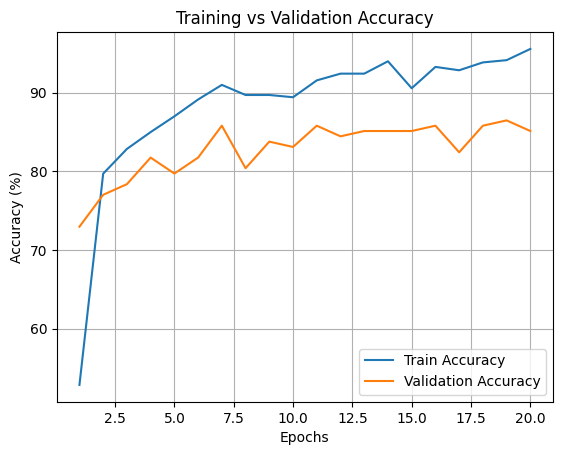

In [10]:
import matplotlib.pyplot as plt

plt.plot(range(1, epochs+1), train_acc_list, label='Train Accuracy')
plt.plot(range(1, epochs+1), val_acc_list, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [11]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# Classification report
print("Classification Report:\n", classification_report(all_labels, all_preds, target_names=test_data.classes))

# Confusion matrix
print("Confusion Matrix:\n", confusion_matrix(all_labels, all_preds))


Classification Report:
               precision    recall  f1-score   support

Flea_Allergy       0.85      0.87      0.86        38
      Health       0.85      0.92      0.89        38
    Ringworm       0.83      0.66      0.74        38
     Scabies       0.88      0.97      0.93        38

    accuracy                           0.86       152
   macro avg       0.85      0.86      0.85       152
weighted avg       0.85      0.86      0.85       152

Confusion Matrix:
 [[33  0  4  1]
 [ 1 35  1  1]
 [ 5  5 25  3]
 [ 0  1  0 37]]


In [12]:
torch.save(model.state_dict(), "mobilenet-cat_disease_model.pth")


In [13]:
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())


In [14]:
from sklearn.metrics import confusion_matrix
import numpy as np

cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:\n", cm)


Confusion Matrix:
 [[33  0  4  1]
 [ 1 35  1  1]
 [ 5  5 25  3]
 [ 0  1  0 37]]


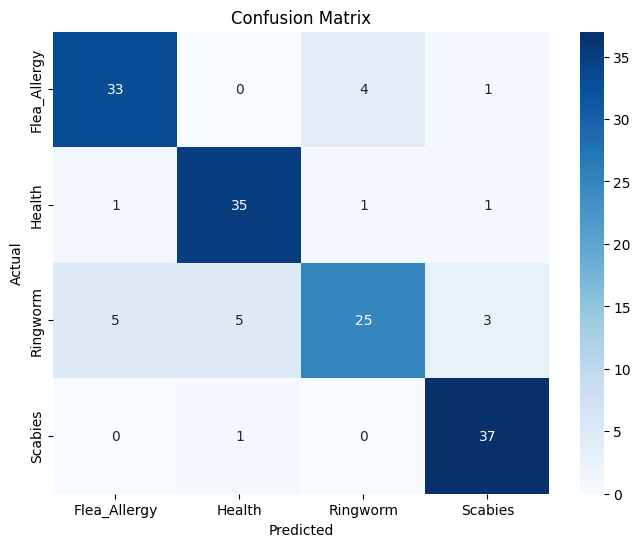

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define class names
class_names = test_data.classes

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [16]:
from sklearn.metrics import classification_report

# Generate a report
report = classification_report(all_labels, all_preds, target_names=test_data.classes, output_dict=True)

# Convert to a readable table
import pandas as pd

df_report = pd.DataFrame(report).transpose()
df_report = df_report.round(3)  # Round off to 3 decimal places

# Display the report
df_report


precision  recall  f1-score  support
Flea_Allergy      0.846   0.868     0.857   38.000
Health            0.854   0.921     0.886   38.000
Ringworm          0.833   0.658     0.735   38.000
Scabies           0.881   0.974     0.925   38.000
accuracy          0.855   0.855     0.855    0.855
macro avg         0.854   0.855     0.851  152.000
weighted avg      0.854   0.855     0.851  152.000

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Reverse class index to name
idx_to_class = {v: k for k, v in test_data.class_to_idx.items()}

# Store misclassified images
misclassified = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        
        # Compare predictions and labels
        for i in range(len(labels)):
            if preds[i] != labels[i]:
                misclassified.append((images[i].cpu(), preds[i].item(), labels[i].item()))

print(f"Total Misclassified Images: {len(misclassified)}")


Total Misclassified Images: 22


C:\Users\HP\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


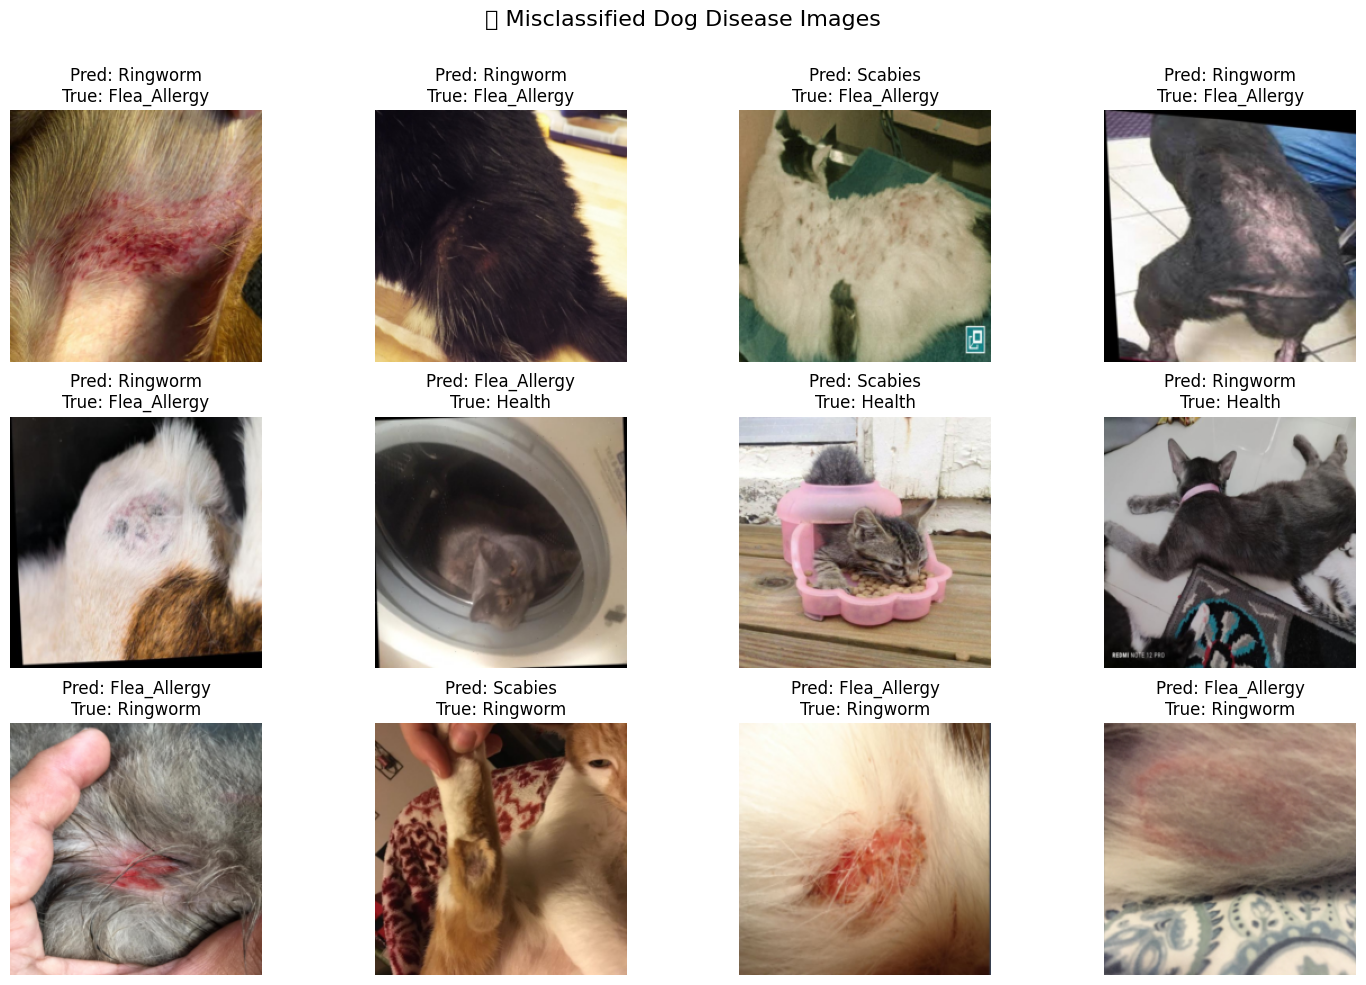

In [18]:
num_images = min(12, len(misclassified))
plt.figure(figsize=(15, 10))

for i in range(num_images):
    image, pred_idx, true_idx = misclassified[i]
    image = image.permute(1, 2, 0).numpy()  # Convert from [C, H, W] to [H, W, C]
    
    plt.subplot(3, 4, i+1)
    plt.imshow(image)
    plt.title(f"Pred: {idx_to_class[pred_idx]}\nTrue: {idx_to_class[true_idx]}")
    plt.axis('off')

plt.tight_layout()
plt.suptitle("❌ Misclassified Dog Disease Images", fontsize=16)
plt.subplots_adjust(top=0.88)
plt.show()


In [19]:
correct_classified = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        
        for i in range(len(labels)):
            if preds[i] == labels[i]:
                correct_classified.append((images[i].cpu(), preds[i].item(), labels[i].item()))

print(f"Total Correctly Classified Images: {len(correct_classified)}")


Total Correctly Classified Images: 130


C:\Users\HP\AppData\Local\Temp\ipykernel_4028\3806512793.py:13: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\HP\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


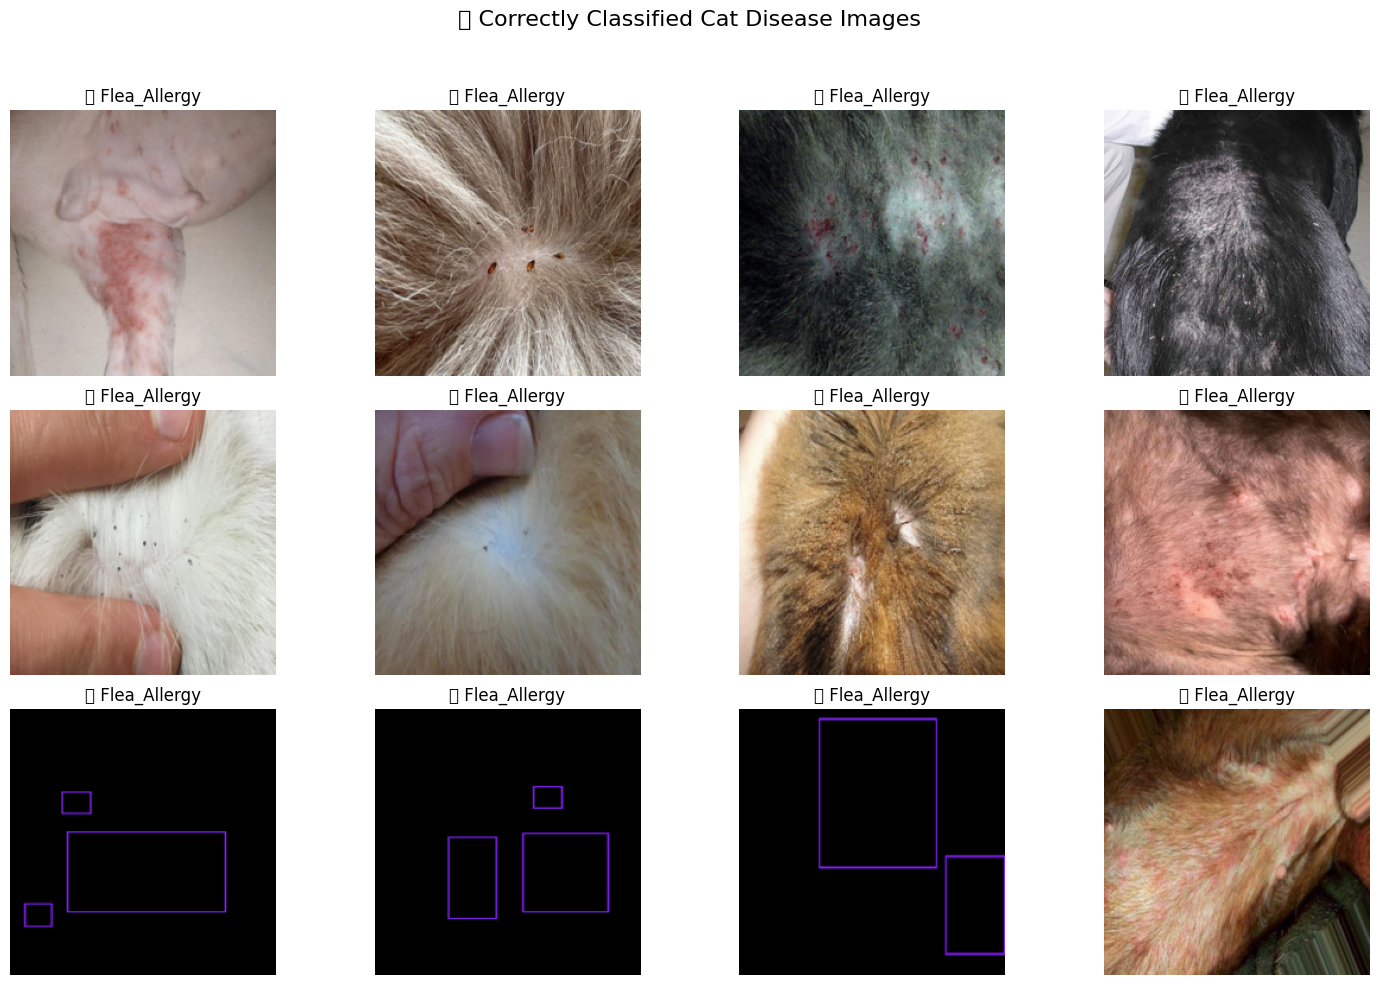

In [20]:
num_images = min(12, len(correct_classified))
plt.figure(figsize=(15, 10))

for i in range(num_images):
    image, pred_idx, true_idx = correct_classified[i]
    image = image.permute(1, 2, 0).numpy()  # C, H, W → H, W, C
    
    plt.subplot(3, 4, i+1)
    plt.imshow(image)
    plt.title(f"✅ {idx_to_class[pred_idx]}")
    plt.axis('off')

plt.tight_layout()
plt.suptitle("✅ Correctly Classified Cat Disease Images", fontsize=16)
plt.subplots_adjust(top=0.88)
plt.show()


In [21]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import preprocess_image


In [22]:
from pytorch_grad_cam import GradCAM

# Ensure model is on the right device
model.to(device)
model.eval()

# Target last conv layer of MobileNetV2
target_layer = model.features[-1]

# Initialize GradCAM without use_cuda
cam = GradCAM(model=model, target_layers=[target_layer])


In [23]:
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

def visualize_gradcam(image_tensor, label_idx, title=""):
    rgb_img = image_tensor.permute(1, 2, 0).numpy()
    rgb_img = np.float32(rgb_img)
    input_tensor = image_tensor.unsqueeze(0).to(device)

    targets = [ClassifierOutputTarget(label_idx)]

    with GradCAM(model=model, target_layers=[target_layer]) as cam:
        grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]
        visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

    plt.imshow(visualization)
    plt.title(title)
    plt.axis('off')


In [24]:
def visualize_gradcam(image_tensor, label_idx, title=""):
    rgb_img = image_tensor.permute(1, 2, 0).numpy()
    rgb_img = np.float32(rgb_img)
    input_tensor = image_tensor.unsqueeze(0).to(device)

    targets = [ClassifierOutputTarget(label_idx)]

    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]
    visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

    plt.imshow(visualization)
    plt.title(title)
    plt.axis('off')


In [25]:
def get_model(num_classes):
    model = models.mobilenet_v2(pretrained=True)

    # Freeze all layers
    for param in model.parameters():
        param.requires_grad = False

    # UNFREEZE only last conv layer for Grad-CAM to work
    for param in model.features[-1].parameters():
        param.requires_grad = True

    # Replace classifier
    model.classifier[1] = nn.Linear(model.last_channel, num_classes)
    
    return model


In [26]:
model = get_model(num_classes).to(device)
model.eval()


c:\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [27]:
from pytorch_grad_cam import GradCAM
target_layer = model.features[-1]  # last conv layer in MobileNetV2


In [28]:
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

def visualize_gradcam(image_tensor, label_idx, title=""):
    rgb_img = image_tensor.permute(1, 2, 0).numpy()
    rgb_img = np.float32(rgb_img)
    input_tensor = image_tensor.unsqueeze(0).to(device)

    targets = [ClassifierOutputTarget(label_idx)]

    with GradCAM(model=model, target_layers=[target_layer]) as cam:
        grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]
        visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

    plt.imshow(visualization)
    plt.title(title)
    plt.axis('off')


C:\Users\HP\AppData\Roaming\Python\Python312\site-packages\IPython\core\events.py:82: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)


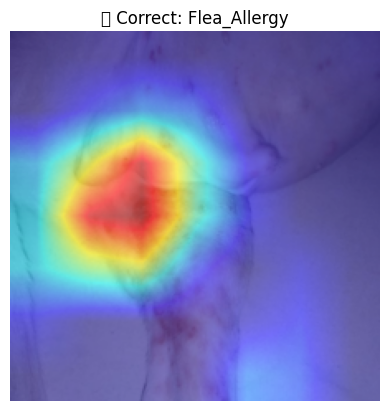

In [29]:
img, pred_idx, true_idx = correct_classified[0]
visualize_gradcam(img, pred_idx, f"✅ Correct: {idx_to_class[pred_idx]}")


C:\Users\HP\AppData\Local\Temp\ipykernel_4028\3277214123.py:9: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\HP\AppData\Local\Temp\ipykernel_4028\3277214123.py:9: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


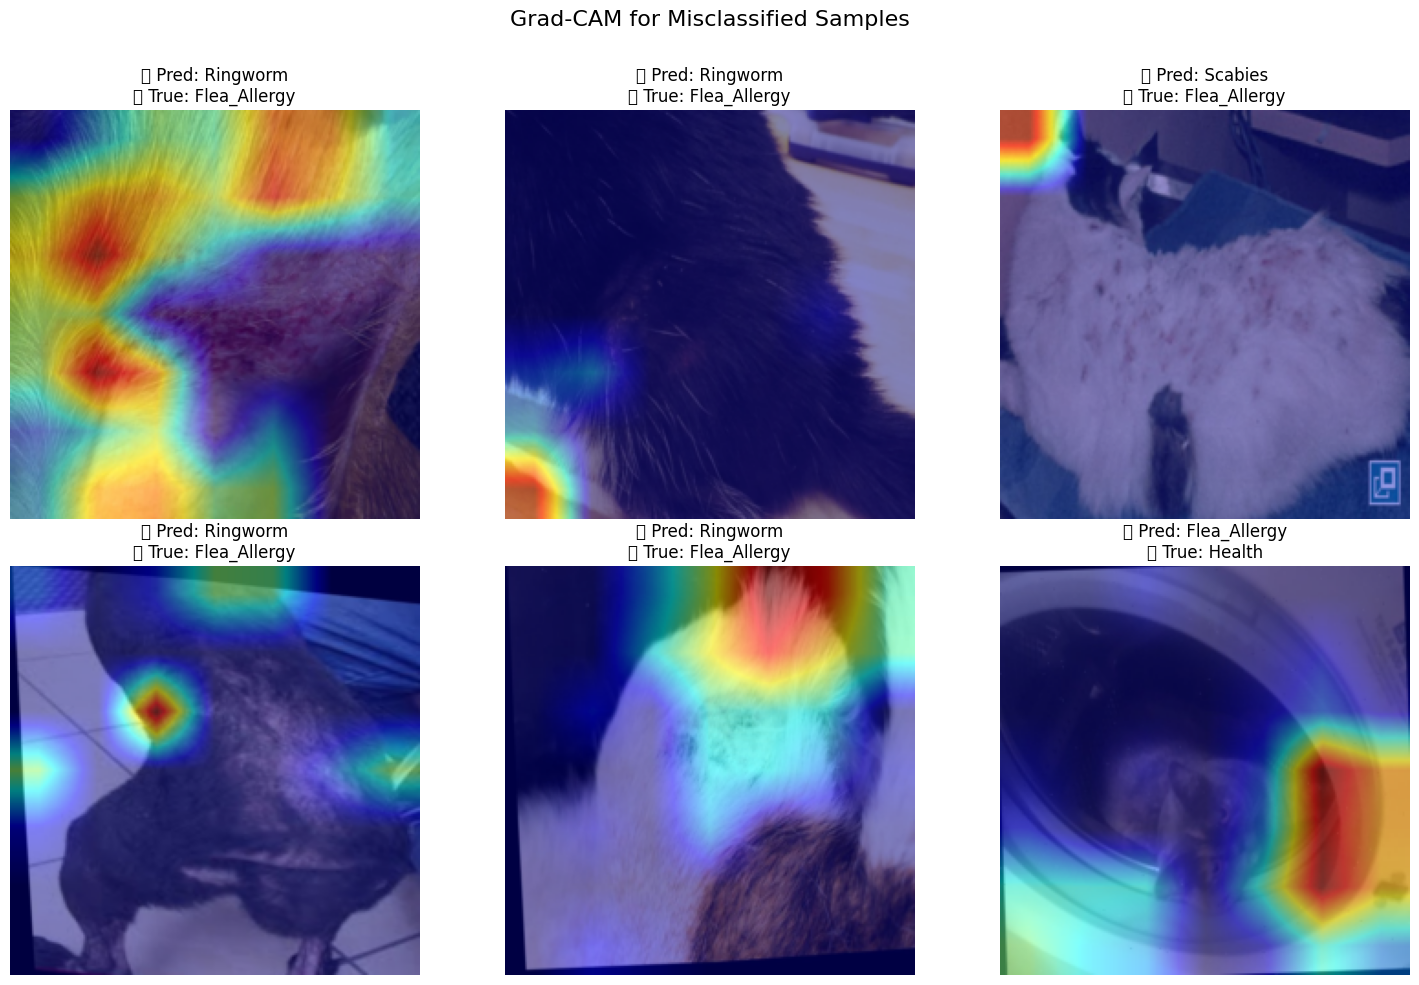

In [30]:
num_mis = min(6, len(misclassified))
plt.figure(figsize=(15, 10))

for i in range(num_mis):
    img, pred_idx, true_idx = misclassified[i]
    plt.subplot(2, 3, i+1)
    visualize_gradcam(img, pred_idx, f"❌ Pred: {idx_to_class[pred_idx]}\n✅ True: {idx_to_class[true_idx]}")

plt.tight_layout()
plt.suptitle("Grad-CAM for Misclassified Samples", fontsize=16)
plt.subplots_adjust(top=0.88)
plt.show()


In [31]:
for name, module in model.named_modules():
    print(name, "->", any(p.requires_grad for p in module.parameters()))


 -> True
features -> True
features.0 -> False
features.0.0 -> False
features.0.1 -> False
features.0.2 -> False
features.1 -> False
features.1.conv -> False
features.1.conv.0 -> False
features.1.conv.0.0 -> False
features.1.conv.0.1 -> False
features.1.conv.0.2 -> False
features.1.conv.1 -> False
features.1.conv.2 -> False
features.2 -> False
features.2.conv -> False
features.2.conv.0 -> False
features.2.conv.0.0 -> False
features.2.conv.0.1 -> False
features.2.conv.0.2 -> False
features.2.conv.1 -> False
features.2.conv.1.0 -> False
features.2.conv.1.1 -> False
features.2.conv.1.2 -> False
features.2.conv.2 -> False
features.2.conv.3 -> False
features.3 -> False
features.3.conv -> False
features.3.conv.0 -> False
features.3.conv.0.0 -> False
features.3.conv.0.1 -> False
features.3.conv.0.2 -> False
features.3.conv.1 -> False
features.3.conv.1.0 -> False
features.3.conv.1.1 -> False
features.3.conv.1.2 -> False
features.3.conv.2 -> False
features.3.conv.3 -> False
features.4 -> False
f

In [32]:
from sklearn.metrics import classification_report, confusion_matrix

# Already available:
# all_preds, all_labels (from test set)
# idx_to_class: dict mapping label idx to class name

report = classification_report(
    all_labels, all_preds,
    target_names=test_data.classes,
    digits=4,
    output_dict=True
)


In [33]:
import pandas as pd

df_report = pd.DataFrame(report).transpose()
df_report


precision    recall  f1-score     support
Flea_Allergy   0.846154  0.868421  0.857143   38.000000
Health         0.853659  0.921053  0.886076   38.000000
Ringworm       0.833333  0.657895  0.735294   38.000000
Scabies        0.880952  0.973684  0.925000   38.000000
accuracy       0.855263  0.855263  0.855263    0.855263
macro avg      0.853525  0.855263  0.850878  152.000000
weighted avg   0.853525  0.855263  0.850878  152.000000

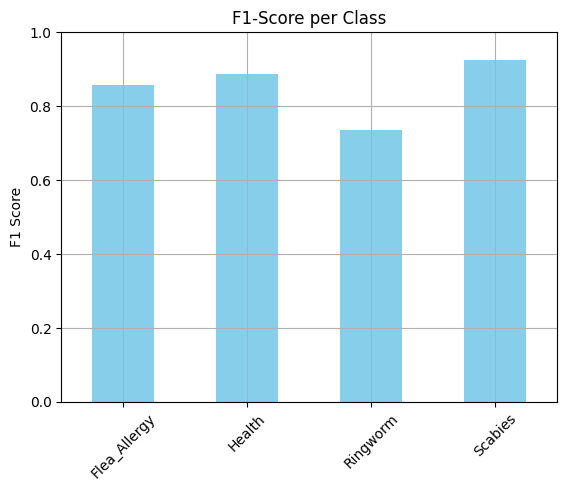

In [34]:
# Plot class-wise F1-scores
df_report[:-3]["f1-score"].plot(kind='bar', color='skyblue')
plt.title("F1-Score per Class")
plt.ylabel("F1 Score")
plt.ylim(0, 1)
plt.grid(True)
plt.xticks(rotation=45)
plt.show()


In [35]:
summary = {
    "Overall Accuracy (%)": 100 * sum(np.array(all_preds) == np.array(all_labels)) / len(all_labels),
    "Precision (Macro)": df_report.loc["macro avg", "precision"],
    "Recall (Macro)": df_report.loc["macro avg", "recall"],
    "F1-Score (Macro)": df_report.loc["macro avg", "f1-score"],
    "Total Test Samples": len(all_labels)
}

pd.DataFrame(summary, index=["Value"]).T


Value
Overall Accuracy (%)   85.526316
Precision (Macro)       0.853525
Recall (Macro)          0.855263
F1-Score (Macro)        0.850878
Total Test Samples    152.000000

In [36]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
from scipy.stats import ttest_ind, chi2_contingency, f_oneway
from statsmodels.stats.inter_rater import cohens_kappa


In [37]:
true = np.array(all_labels)
pred = np.array(all_preds)


In [38]:
# Confusion matrix as contingency table
cm = confusion_matrix(true, pred)

chi2, p, dof, expected = chi2_contingency(cm)

print("Chi-square statistic:", chi2)
print("Degrees of freedom:", dof)
print("p-value:", p)

if p < 0.05:
    print("✅ Reject null hypothesis — there's a significant association between prediction and actual.")
else:
    print("❌ Fail to reject null — predictions may be random.")


Chi-square statistic: 301.43632627535067
Degrees of freedom: 9
p-value: 1.2942070835503103e-59
✅ Reject null hypothesis — there's a significant association between prediction and actual.


In [39]:
from sklearn.metrics import precision_recall_fscore_support

# Get F1 scores by class from sklearn
precision, recall, f1_scores, _ = precision_recall_fscore_support(true, pred)

# Optional: simulate multiple runs if needed
# Here we pretend each class was evaluated in 3 runs with minor noise
np.random.seed(0)
samples = [np.random.normal(loc=score, scale=0.02, size=3) for score in f1_scores]

# Perform ANOVA across classes
f_val, p_val = f_oneway(*samples)
print("ANOVA F-value:", f_val)
print("p-value:", p_val)

if p_val < 0.05:
    print("✅ Significant difference in F1 scores between classes")
else:
    print("❌ No significant difference in F1 scores across classes")


ANOVA F-value: 51.77800903209049
p-value: 1.3882584674983088e-05
✅ Significant difference in F1 scores between classes


In [40]:
from sklearn.metrics import cohen_kappa_score

kappa = cohen_kappa_score(true, pred)
print("Cohen’s Kappa Score:", kappa)

if kappa >= 0.8:
    print("✅ Almost perfect agreement")
elif kappa >= 0.6:
    print("👍 Substantial agreement")
else:
    print("⚠️ Moderate or lower agreement")


Cohen’s Kappa Score: 0.8070175438596492
✅ Almost perfect agreement


In [49]:
# Step 1: Class indexes (now correct)
idx_bacterial = class_names.index('Flea_Allergy')
idx_fungal = class_names.index('Ringworm')

# Step 2: Simulate F1 score samples from model result
sample_bacterial = np.random.normal(loc=f1_scores[idx_bacterial], scale=0.02, size=10)
sample_fungal = np.random.normal(loc=f1_scores[idx_fungal], scale=0.02, size=10)

# Step 3: Perform T-Test
from scipy.stats import ttest_ind

t_stat, p_val = ttest_ind(sample_bacterial, sample_fungal)

# Step 4: Report
print(f"T-Test: Flea_Allergy vs Ringworm")
print("T-statistic:", round(t_stat, 4))
print("p-value:", round(p_val, 4))

if p_val < 0.05:
    print("✅ Significant difference between classes")
else:
    print("❌ No significant difference between classes")


T-Test: Flea_Allergy vs Ringworm
T-statistic: 11.4651
p-value: 0.0
✅ Significant difference between classes


In [42]:
model_a = get_model(num_classes).to(device)
model_a.load_state_dict(torch.load("mobilenet-cat_disease_model.pth"))
model_a.eval()



c:\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [43]:
from torchvision.models import resnet18

def get_model_resnet(num_classes):
    model = resnet18(pretrained=True)
    
    # Freeze all layers
    for param in model.parameters():
        param.requires_grad = False

    # Unfreeze last conv block
    for param in model.layer4.parameters():
        param.requires_grad = True

    # Replace classifier
    model.fc = nn.Linear(model.fc.in_features, num_classes)

    return model


In [44]:
model_b = get_model_resnet(num_classes).to(device)


c:\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [45]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model_b.parameters()), lr=0.001)

# Train model_b for a few epochs (e.g. 5–10)
for epoch in range(5):
    model_b.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model_b(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1} Loss: {running_loss:.4f}")


Epoch 1 Loss: 13.3752
Epoch 2 Loss: 3.4650
Epoch 3 Loss: 0.9381
Epoch 4 Loss: 0.3674
Epoch 5 Loss: 0.2655


In [46]:
model_b.eval()
torch.save(model_b.state_dict(), "resnet_cat_disease.pth")


In [47]:
from torch.utils.data import DataLoader

model_a_preds = []
model_b_preds = []
true_labels = []

model_a.eval()
model_b.eval()

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)

        out_a = model_a(images)
        out_b = model_b(images)

        pred_a = out_a.argmax(dim=1).cpu().numpy()
        pred_b = out_b.argmax(dim=1).cpu().numpy()
        labels = labels.numpy()

        model_a_preds.extend(pred_a)
        model_b_preds.extend(pred_b)
        true_labels.extend(labels)


In [48]:
from statsmodels.stats.contingency_tables import mcnemar

# Convert to numpy arrays
a_preds = np.array(model_a_preds)
b_preds = np.array(model_b_preds)
y_true = np.array(true_labels)

# Build 2x2 contingency table
# [A_correct & B_correct, A_correct & B_wrong]
# [A_wrong & B_correct,  A_wrong & B_wrong]
a_correct = (a_preds == y_true)
b_correct = (b_preds == y_true)

both_correct = np.sum(a_correct & b_correct)
a_only = np.sum(a_correct & ~b_correct)
b_only = np.sum(~a_correct & b_correct)
both_wrong = np.sum(~a_correct & ~b_correct)

# Build table
table = [[both_correct, a_only],
         [b_only,       both_wrong]]

# Perform McNemar's test
result = mcnemar(table, exact=True)
print("McNemar’s Test")
print("Chi-square statistic:", result.statistic)
print("p-value:", result.pvalue)

if result.pvalue < 0.05:
    print("✅ Significant difference in predictions (models are statistically different)")
else:
    print("❌ No significant difference (models perform similarly)")


McNemar’s Test
Chi-square statistic: 4.0
p-value: 0.049041748046875
✅ Significant difference in predictions (models are statistically different)
